In [19]:
import pandas as pd
import numpy as np
from pathlib import Path
import os 
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, accuracy_score, confusion_matrix, r2_score
from sklearn.metrics import log_loss,auc,classification_report,roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, label_binarize
from sklearn import tree
import graphviz
import sklearn

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, manifold, ensemble, decomposition
from time import time

pd.set_option('display.max_columns', None)
%matplotlib inline
import sys
sys.path.append("..")
from ICM_utils import helper, evaluation, metrics
results_path = str(Path(os.getcwd()).parents[1]) + "/results/random_forests/"
import ICM_utils as utils

In [2]:
import importlib
importlib.reload(evaluation)
importlib.reload(helper);
importlib.reload(sns);

## 1. Amelia imputed dataset using no censoring (full data)
* Done: GBM treatment is separate, not doing very well
* Ongoing: TSNE visualization
* Ongoing: Understand what classes get confused

* Ongoing: Run on missing dataset
* Ongoing: Split the data into categories based on Alex's clustering 
           Rather than doing this, I suggest we try to classify based on your clusters directly.
* Ongoing: What is a good baseline for Marc? 
* Red: What about the Cox survival analysis model that people have been applying?

## 2. IDEAS: 
 * Use the log variable for life expectancy? do regression? 
 * How else can we split the target variable? 
 * Find ffs some data exploration tool
 
Below plot just shows relation between variables and predictor as pairplot (joint distribution)
Should be able to do this for everything
* Observe how for tumor grade 4 the blue part is highly likely - you'll leave less then 1.5 years unfortunately. 
* Looking at life expectancy and age surgery we see no obvious relationship, other than it's slightly to the left, so younger patients should live longer. 
* For IK it's the exact opposite, it seems that patients with IK will survive longer

## 3. Encodings: 
* Categorical, no order - only used for visualization purposes
* Dummies
* Label Encoder is used only for visualization purposes, we use One-hot-encoding (dummies) for our analysis

In [3]:
IMC_basedir = os.getcwd().split('code')[0]
DATA_Amelia_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_Amelia1.csv')
DATA_MICE_FILE = os.path.join(IMC_basedir, 'data/imputed_dataset_no_censoring_26022018_MICE.csv')
TRAIN_FILE = os.path.join(IMC_basedir, 'data/amelia_train')
TEST_FILE = os.path.join(IMC_basedir, 'data/amelia_test')
MODEL_DIR = os.path.join(IMC_basedir, 'data/amelia_model')
DATA_CENSORING_MICE = os.path.join(IMC_basedir, 'data/imputed_dataset_with_censoring_26022018_MICE_original.csv')

In [5]:
# Load the raw dataset
df_mice = pd.read_csv(DATA_MICE_FILE)
# Only difference from the one before
df_mice = df_mice[df_mice.Tumor_type == "GBM"]

(array([  2.,   1.,   4.,  18.,  44., 161., 437., 431.,  97.,   6.]),
 array([0.        , 0.87750859, 1.75501719, 2.63252578, 3.51003437,
        4.38754297, 5.26505156, 6.14256015, 7.02006875, 7.89757734,
        8.77508594]),
 <a list of 10 Patch objects>)

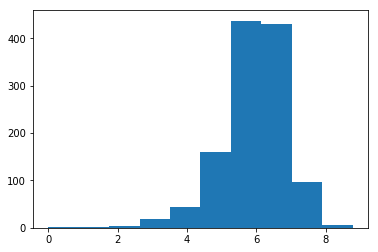

In [8]:
plt.hist((np.log(df_mice.life_expectancy)))

In [9]:
labels = ["1 year","2 years","more"]
cut_points = [300,700]

df_standardized = df_mice.copy(deep=True)

col_names = ['Age_surgery', 'IK']
features = df_standardized[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df_standardized[col_names] = features


# Dummies dataset, used for analysis
df_dummies, labels = helper.process_dataset(df_mice,labels,cut_points)
df_dummies_standardized, labels_standardized = helper.process_dataset(df_standardized, labels, cut_points)

# Label Encoded Dataset, used for visualization
df_encoded, le_dict = helper.label_encoder(df_mice, labels, cut_points)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(array([  2.,   1.,   4.,  18.,  44., 161., 437., 431.,  97.,   6.]),
 array([0.        , 0.87750859, 1.75501719, 2.63252578, 3.51003437,
        4.38754297, 5.26505156, 6.14256015, 7.02006875, 7.89757734,
        8.77508594]),
 <a list of 10 Patch objects>)

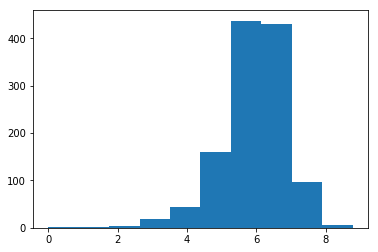

In [10]:
plt.hist(np.log(df_dummies.life_expectancy),bins =10)

In [14]:
df_dummies.columns

Index(['Gender', 'Tumor_grade', 'Age_surgery', 'life_expectancy', 'TERT',
       'IDH_TERT', 'IK', 'life_expectancy_bin', 'Gene_Egfr_AMPLIFIE',
       'Gene_Egfr_NORMAL', 'Surgery_type_aucune', 'Surgery_type_biopsie',
       'Surgery_type_exérèse', 'Surgery_type_partielle', 'Gene_P16_DELETE',
       'Gene_P16_NORMAL', 'Gene_P53_ALTERE', 'Gene_P53_NC', 'Gene_P53_NORMAL',
       'X1p19q_codel_0', 'X1p19q_codel_1', 'Tumor_Location_A',
       'Tumor_Location_B', 'Tumor_Location_C', 'Tumor_Location_N',
       'Tumor_Location_autre', 'Gene_Ihc_Atrx_Extinction diffuse',
       'Gene_Ihc_Atrx_Maintien', 'Gene_Ihc_Atrx_extinction',
       'Tumor_Position_D', 'Tumor_Position_G', 'Tumor_Position_bilatéral',
       'Tumor_Position_médian', 'Tumor_Position_non précisé',
       'Gene_Mgmt_METHYLE', 'Gene_Mgmt_NON METHYLE', 'Gene_Mdm2_AMPLIFIE',
       'Gene_Mdm2_NORMAL', 'Gene_Ch9P_GAIN', 'Gene_Ch9P_NON PERTE',
       'Gene_Ch9P_PERTE', 'Gene_Cdk4_AMPLIFIE', 'Gene_Cdk4_NORMAL',
       'Tumor_type_GB

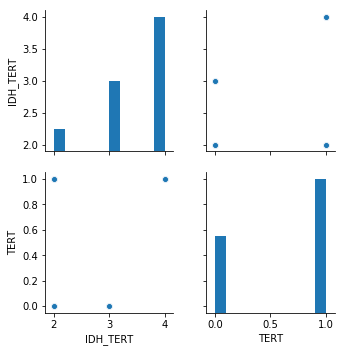

In [11]:
sns.pairplot(data=df_dummies,vars=["IDH_TERT","TERT"]);
#hue='life_expectancy',size=3,kind='scatter'
#g = sns.pairplot(data=df_amelia,hue='life_expectancy_bin',size=3,kind='scatter')

In [13]:
# Display all posibilities for dataframe
helper.display_values(df_mice)

Number of values for attribute Unnamed: 0: 1201
Number of values for attribute Gender: 2 -- ['F' 'M']
Number of values for attribute Tumor_type: 1 -- ['GBM']
Number of values for attribute Tumor_grade: 1 -- [4]
Number of values for attribute Gene_P53: 3 -- ['ALTERE' 'NC' 'NORMAL']
Number of values for attribute Gene_Mgmt: 2 -- ['METHYLE' 'NON METHYLE']
Number of values for attribute Gene_Egfr: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Mdm2: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_Cdk4: 2 -- ['AMPLIFIE' 'NORMAL']
Number of values for attribute Gene_P16: 2 -- ['DELETE' 'NORMAL']
Number of values for attribute Gene_Ihc_Atrx: 3 -- ['Extinction diffuse' 'Maintien' 'extinction']
Number of values for attribute Gene_Ch10Q: 2 -- ['NON PERTE' 'PERTE']
Number of values for attribute Gene_Ch9P: 3 -- ['GAIN' 'NON PERTE' 'PERTE']
Number of values for attribute Tumor_Location: 5 -- ['A' 'B' 'C' 'N' 'autre']
Number of values for attribute Tumor_Position: 5 -

## Create training and validation/test (hold-out validation)
    * You can see how there's a lot less data with just GBM patients

In [15]:
random_states = [1332, 1, 5 ,8, 100, 78]
X_train, Y_train, X_test, Y_test = helper.get_train_test_data(df_dummies,random_state=random_states[0])

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
X_train.head(2)

(960, 47) (241, 47) (960,) (241,)


/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,IDH_NC,IDH_mutant,IDH_wt,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
1605,1,4,55,0,3,60,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,1,0,1,1,0,0,0,1
1532,0,4,63,1,4,90,1,0,0,0,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1,0,1


In [16]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

# Logistic Regression 

In [17]:
l = np.array(labels)
base_lg = LogisticRegressionCV(Cs=100,penalty='l2',cv=5,multi_class='multinomial',random_state=random_states[1],max_iter=10000)
base_lg.fit(X_train,Y_train)
probas = base_lg.predict_proba(X_test)
error = log_loss(Y_test, probas)
print("For {0} class problem using base Logistic Regression --- Harsh Accuracy: {1} and Logloss: {2}".format(len(labels), base_lg.score(X_test,Y_test), error))

For 3 class problem using base Logistic Regression --- Harsh Accuracy: 0.5560165975103735 and Logloss: 0.9446954661743163


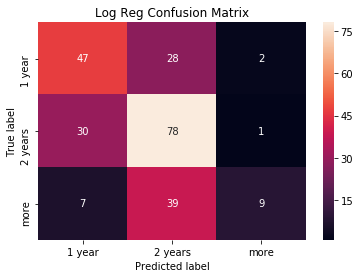

In [18]:
y_pred = base_lg.predict(X_test)
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l,title="Log Reg Confusion Matrix")
#plt.savefig(results_path+"multi_log_reg")

              precision    recall  f1-score   support

      1 year       0.56      0.61      0.58        77
     2 years       0.54      0.72      0.61       109
        more       0.75      0.16      0.27        55

   micro avg       0.56      0.56      0.56       241
   macro avg       0.62      0.50      0.49       241
weighted avg       0.59      0.56      0.53       241

Accuracy: 0.5560165975103735


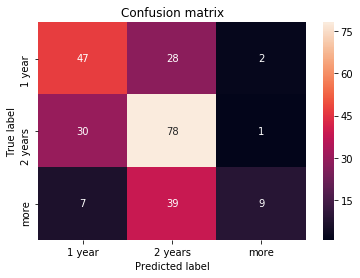

In [20]:
# Very small sample 
utils.plot_report(Y_test, y_pred,labels)

# Random Forest
### Things to think about 
* Data standardization for the continuous variables - it's not necessary for trees. 
  Why is not necessary, again please? 

* Apply MCA to the categories - not so good according to plots from Alex
* Exploratory data analysis is what's missing here
* AUC seems wrong - double check
* Do Cross Validation with KFold
* Tune learning rate? Tune max_depth? Need some wisdom from somewhere on how to take it to the next step
When we do crossvalidation we'll have a different approach. Perform perhaps MCA
  * Random Forests - done below
  * Wide and Deep NN with Tensorflow - done in a separate notebook
  * K-Means style clustering

In [21]:
X_train.describe(include=[np.number])

,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,IDH_NC,IDH_mutant,IDH_wt,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
count,960.000000,960.0,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.000000,960.0,960.000000,960.000000,960.000000,960.000000,960.000000
mean,0.596875,4.0,59.171875,0.623958,3.477083,79.166667,0.384375,0.615625,0.015625,0.330208,0.312500,0.341667,0.417708,0.582292,0.048958,0.810417,0.140625,0.960417,0.039583,0.934375,0.010417,0.004167,0.050000,0.001042,0.040625,0.851042,0.108333,0.456250,0.453125,0.038542,0.003125,0.048958,0.444792,0.555208,0.162500,0.837500,0.052083,0.437500,0.510417,0.185417,0.814583,1.0,0.115625,0.044792,0.839583,0.246875,0.753125
std,0.490781,0.0,12.978632,0.484643,0.676968,11.441164,0.486701,0.486701,0.124084,0.470533,0.463754,0.474516,0.493439,0.493439,0.215893,0.392176,0.347816,0.195080,0.195080,0.247755,0.101582,0.064449,0.218059,0.032275,0.197523,0.356233,0.310963,0.498342,0.498057,0.192600,0.055843,0.215893,0.497202,0.497202,0.369101,0.369101,0.222311,0.496337,0.500152,0.388838,0.388838,0.0,0.319941,0.206954,0.367183,0.431418,0.431418
min,0.000000,4.0,18.000000,0.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.0,51.000000,0.000000,3.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000
50%,1.000000,4.0,60.000000,1.000000,4.000000,80.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000
75%,1.000000,4.0,68.000000,1.000000,4.000000,90.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.0,0.000000,0.000000,1.000000,0.000000,1.000000
max,1.000000,4.0,88.000000,1.000000,4.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00

In [22]:
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

### Baseline Random Forest classifier 

In [23]:
l = np.array(labels)
base_rfc = RandomForestClassifier(n_estimators = 500, random_state=1233)
base_rfc.fit(X_train, Y_train)
probas = base_rfc.predict_proba(X_test)
#y_pred_probas = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Score: {1} and Logloss: {2}".format(len(labels), base_rfc.score(X_test,Y_test), error))

For 3 class problem --- Score: 0.4854771784232365 and Logloss: 1.0055095107299012


In [24]:
y_pred = base_rfc.predict(X_test)

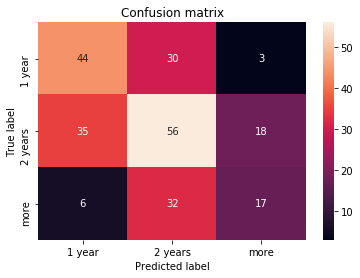

In [25]:
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l)

Side Note: this is quite bad, need to do something to it - baseline though`

### Grid Search - I didn't run this on the three class problem 
**Only run in the CLOUD**

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
# Create a model with 400 estimators for the grid search
rfc = RandomForestClassifier(random_state = 1233)


# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    "criterion": ["gini", "entropy"],
    "n_estimators": [10,20,50,100,300,400,500,1000,1500,2000]
}
#"max_features": ['auto','log2']


# Instantiate GRID SEARCH over the space of parameters defined 
# Should we play with CV? 
grid_search = GridSearchCV(estimator = rfc, param_grid=param_grid, 
                           n_jobs = -1, verbose = 2, # Do we need jobs and verbose to change?
                           scoring='neg_log_loss', cv = 3, return_train_score=True)

# Fit the model - should not show processing 
grid_search.fit(X_train, Y_train);

In [28]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 500}

In [29]:
best_grid = grid_search.best_estimator_
#grid_accuracy = evaluate(best_grid, test_features, test_labels) - what is this one? what are the test_features? 
best_grid

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)

              precision    recall  f1-score   support

      1 year       0.58      0.58      0.58        77
     2 years       0.54      0.72      0.62       109
        more       0.74      0.25      0.38        55

   micro avg       0.57      0.57      0.57       241
   macro avg       0.62      0.52      0.53       241
weighted avg       0.60      0.57      0.55       241

Accuracy: 0.5726141078838174


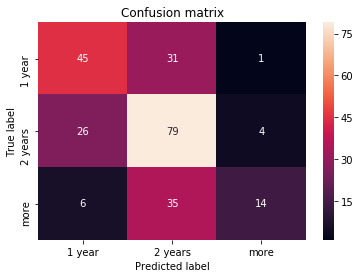

In [27]:
rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)

rfc.fit(X_train, Y_train)



# Accuracy on test
accuracy = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

# Confusion matrix and report     
#cfm = confusion_matrix(Y_test, l[y_pred])
evaluation.plot_report(Y_test, l[y_pred], labels)

In [29]:
print(error)

0.9475215154228168


**Better Model after tunning**

## Final Model for Random Forests
* If CV doesn't contain results, use previous Grid CV results
* If CV contains results, use them, but will only work on cloud

              precision    recall  f1-score   support

      1 year       0.59      0.60      0.59        77
     2 years       0.55      0.72      0.62       109
        more       0.74      0.25      0.38        55

   micro avg       0.58      0.58      0.58       241
   macro avg       0.63      0.53      0.53       241
weighted avg       0.60      0.58      0.56       241

Accuracy: 0.5767634854771784
For 3 class problem --- Accuracy: 0.5767634854771784 and Logloss: 0.9481372107703833


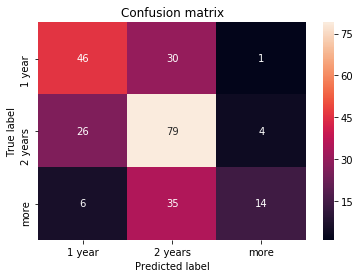

In [30]:
# Random forests with the right number of estimators based on validation set
# rfc = best result from above
rfc=RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=80, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=1233, verbose=0,
            warm_start=False)
    
rfc.fit(X_train, Y_train)
    
score = rfc.score(X_test,Y_test)
    
# XEntropy Error
probas = rfc.predict_proba(X_test)
y_pred = rfc.predict(X_test)
#np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
    
# Confusion matrix      
#cfm = confusion_matrix(Y_test, l[y_pred])
evaluation.plot_report(Y_test, y_pred, labels)
   
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), score, error))    
# ROC-AUC needs fixing.  
#Y_test_binary = label_binarize(Y_test, classes=labels)
#y_pred_binary = label_binarize(l[y_pred],classes =labels)
#auc_curve = evaluation.multi_class_auc(len(l),Y_test_binary,y_pred_binary)

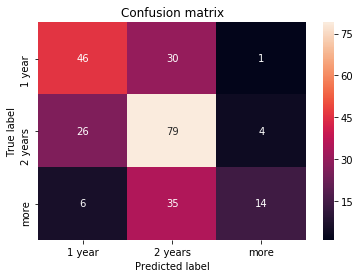

In [32]:
cm = evaluation.confusion_matrix(Y_test,y_pred,l)
evaluation.plot_confusion_matrix(cm,l)
plt.savefig(results_path + "cm_mice_3class_GBM")

## Inspect confusion points

In [33]:
confused12 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[1])
confused1more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[0],labels[2])

confused21 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[0])
confused2more = evaluation.confused_entries(X_test,Y_test,y_pred,labels[1],labels[2])

confusedmore1 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[0])
confusedmore2 = evaluation.confused_entries(X_test,Y_test,y_pred,labels[2],labels[1])

In [34]:
confused12.head(1)

,Gender,Tumor_grade,Age_surgery,TERT,IDH_TERT,IK,Gene_Egfr_AMPLIFIE,Gene_Egfr_NORMAL,Surgery_type_aucune,Surgery_type_biopsie,Surgery_type_exérèse,Surgery_type_partielle,Gene_P16_DELETE,Gene_P16_NORMAL,Gene_P53_ALTERE,Gene_P53_NC,Gene_P53_NORMAL,X1p19q_codel_0,X1p19q_codel_1,Tumor_Location_A,Tumor_Location_B,Tumor_Location_C,Tumor_Location_N,Tumor_Location_autre,Gene_Ihc_Atrx_Extinction diffuse,Gene_Ihc_Atrx_Maintien,Gene_Ihc_Atrx_extinction,Tumor_Position_D,Tumor_Position_G,Tumor_Position_bilatéral,Tumor_Position_médian,Tumor_Position_non précisé,Gene_Mgmt_METHYLE,Gene_Mgmt_NON METHYLE,Gene_Mdm2_AMPLIFIE,Gene_Mdm2_NORMAL,Gene_Ch9P_GAIN,Gene_Ch9P_NON PERTE,Gene_Ch9P_PERTE,Gene_Cdk4_AMPLIFIE,Gene_Cdk4_NORMAL,Tumor_type_GBM,IDH_NC,IDH_mutant,IDH_wt,Gene_Ch10Q_NON PERTE,Gene_Ch10Q_PERTE
381,1,4,36,0,3,90,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,1,1,0


## We are working only with GBM
We can look at IDH Tert instead - basically find something interesting for this case 

**TODO: print it with seaborn** 

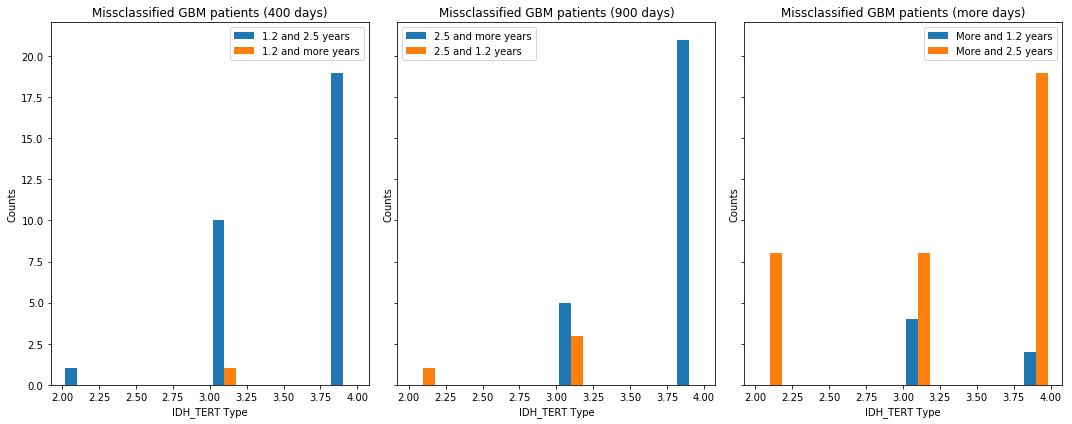

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15,6),sharey=True, sharex=True)
#ax.set_xlabel("GBM Tumor Type")
#ax.set_ylabel("Count")
#ax[0].hist(confused21.Tumor_type_GBM)
axes[0].hist([confused12.IDH_TERT,confused1more.IDH_TERT],label=['1.2 and 2.5 years', '1.2 and more years'])
axes[0].legend()
axes[0].set_title("Missclassified GBM patients (400 days)")

axes[1].hist([confused21.IDH_TERT,confused2more.IDH_TERT],label=['2.5 and more years', '2.5 and 1.2 years'])
axes[1].legend()
axes[1].set_title("Missclassified GBM patients (900 days)")

axes[2].hist([confusedmore1.IDH_TERT,confusedmore2.IDH_TERT],label=['More and 1.2 years', 'More and 2.5 years'])
axes[2].legend()
axes[2].set_title("Missclassified GBM patients (more days)")


# FIX it such that you only have one legend and only one y axis. 
for ax in axes:
    ax.set_xlabel("IDH_TERT Type")
    ax.set_ylabel("Counts")

fig.tight_layout()
#fig.savefig(results_path + "GBM histograms for missclassfied patients")

In [45]:
# Reconstruct the dataframes as in the beginning
cf12 = helper.from_dummies(confused12)
cf1more = helper.from_dummies(confused1more)

cf21 = helper.from_dummies(confused21)
cf2more = helper.from_dummies(confused2more)

cfmore1 = helper.from_dummies(confusedmore1)
cfmore2 = helper.from_dummies(confusedmore2)

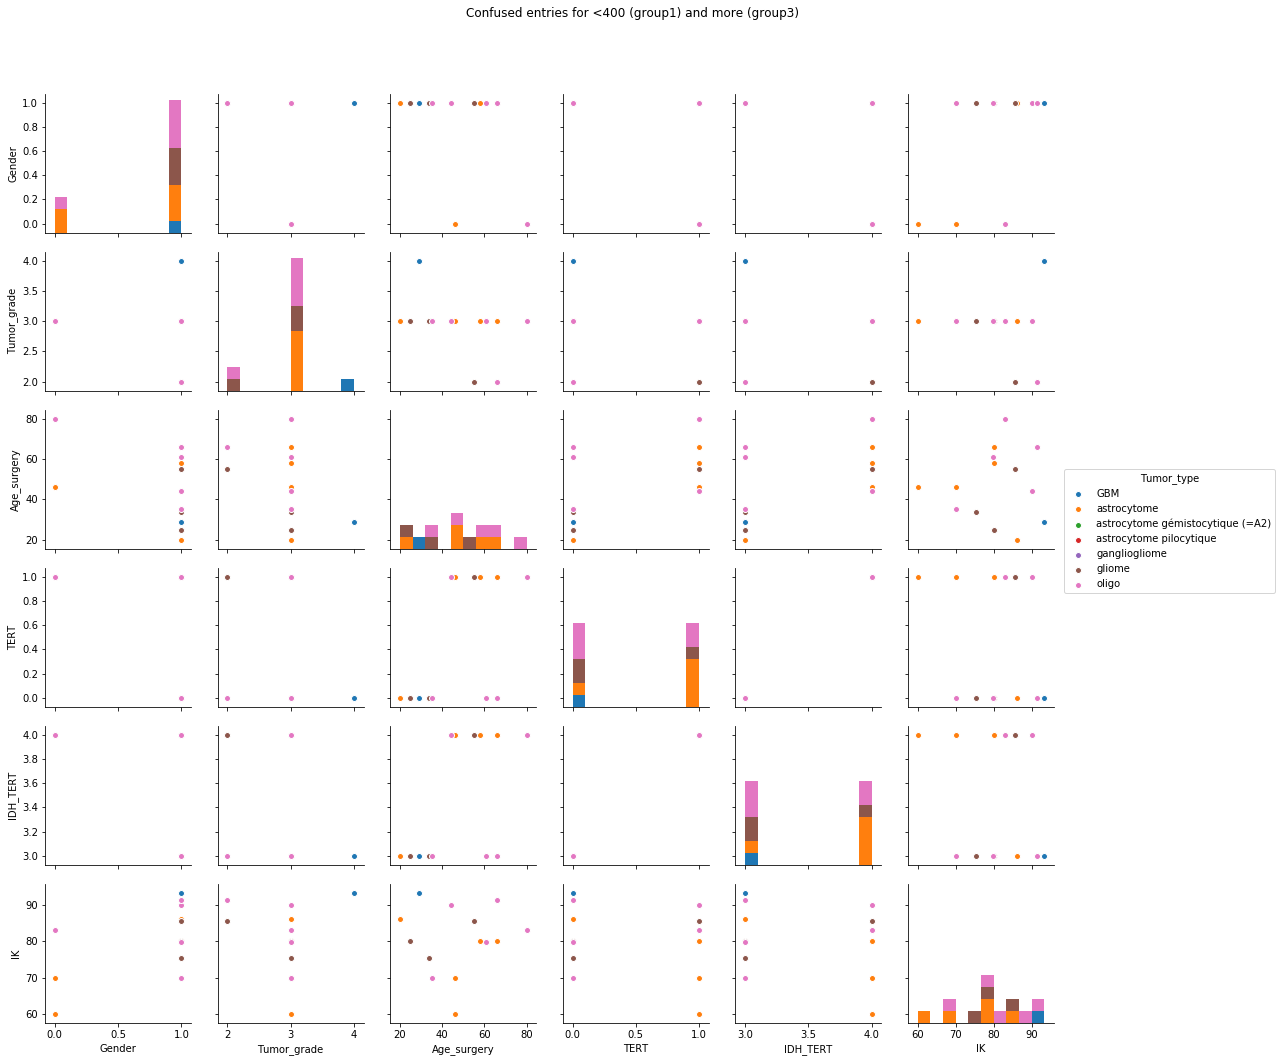

In [61]:
# Pairplot some of the variables
g1 = sns.pairplot(data=cf1more,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type")
plt.subplots_adjust(top=0.9)
g1.fig.suptitle('Confused entries for <400 (group1) and more (group3)') 
g1.savefig(results_path + "1st-2nd Group GBM confused patients")

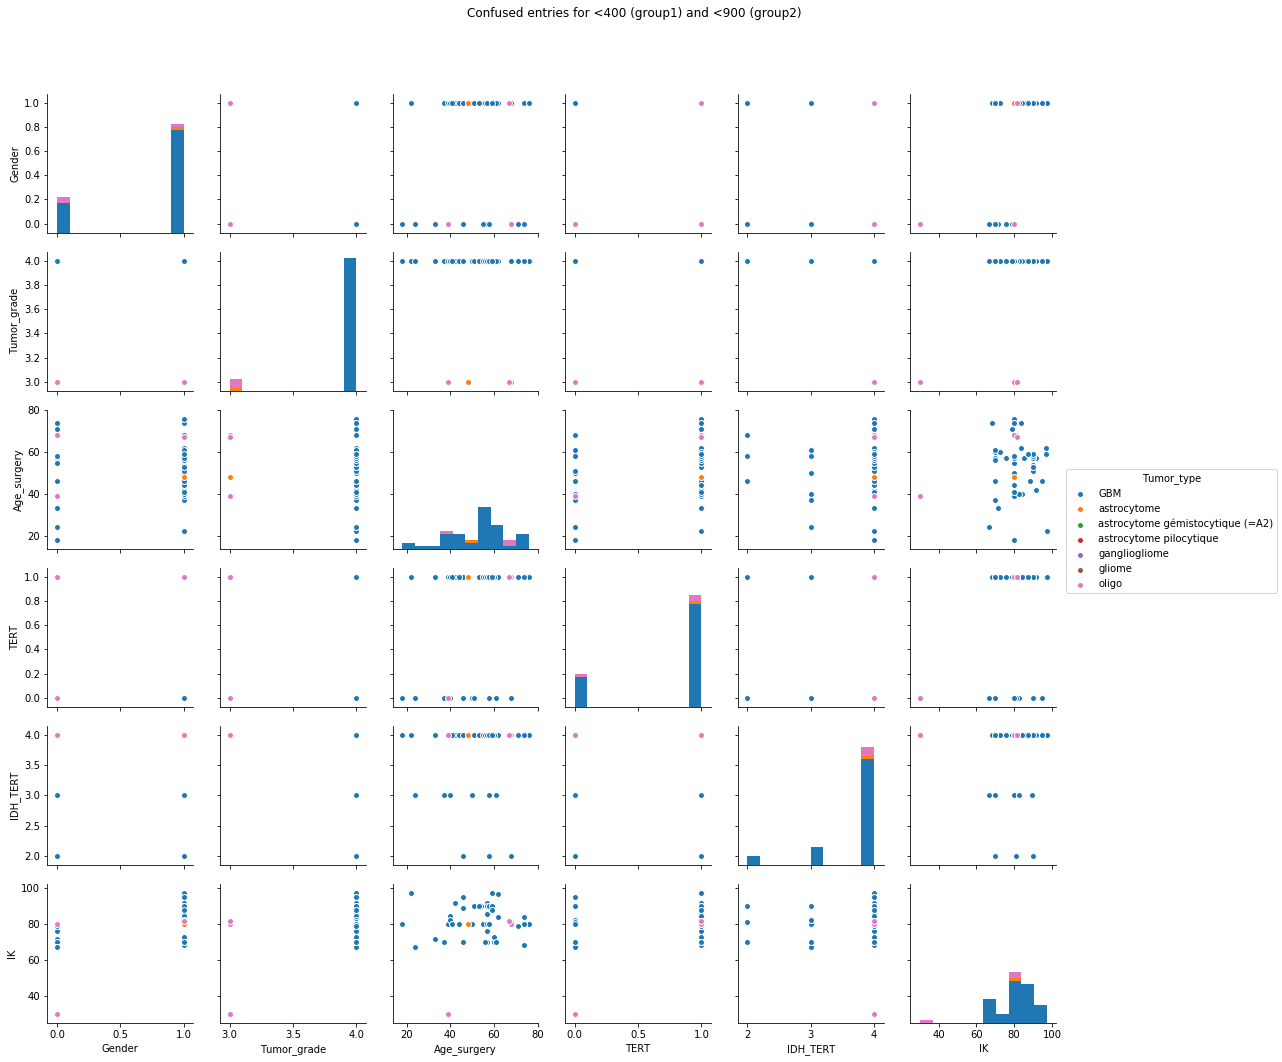

In [62]:
g2 = sns.pairplot(data=cf12,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type")
plt.subplots_adjust(top=0.9)
g2.fig.suptitle('Confused entries for <400 (group1) and <900 (group2)') 
g2.savefig(results_path + "1st-3rd Group GBM confused patients")

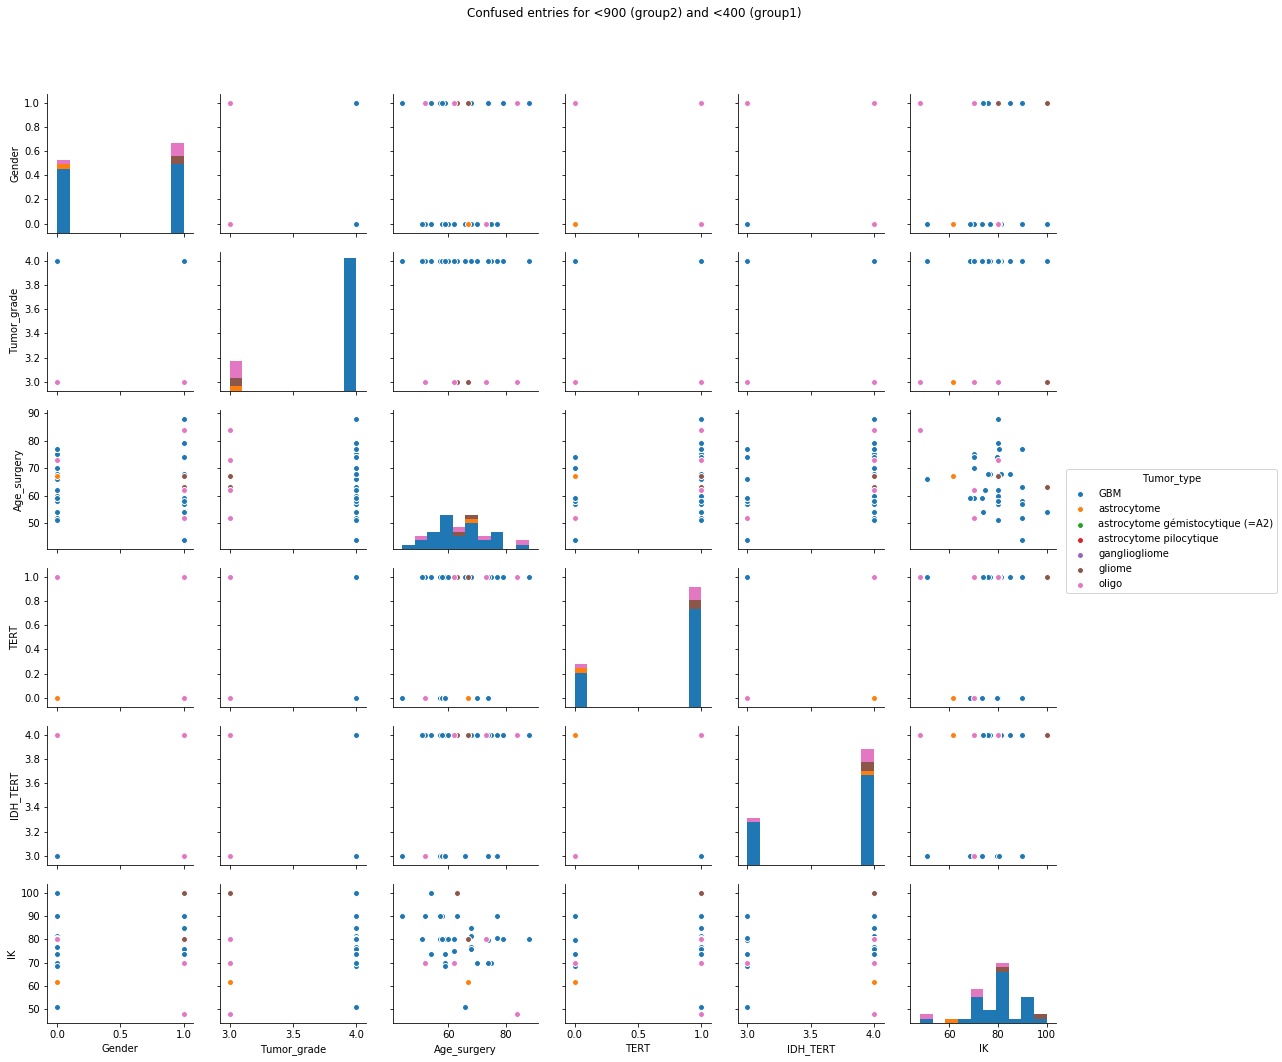

In [63]:
g3 = sns.pairplot(data=cf21,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g3.fig.suptitle('Confused entries for <900 (group2) and <400 (group1)') 
g3.savefig(results_path + "2st-1rd Group GBM confused patients")

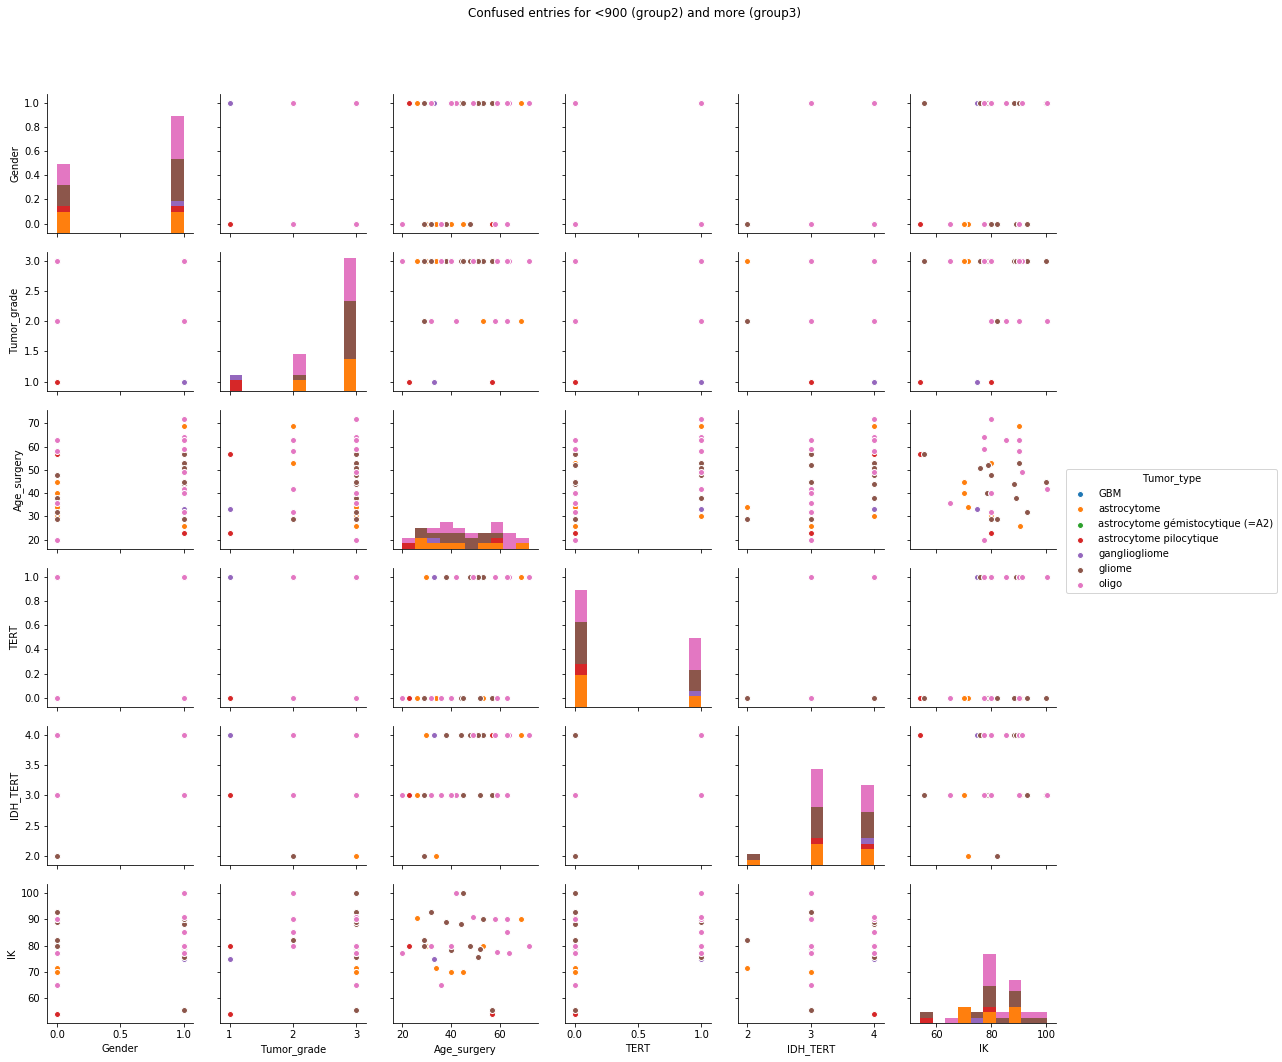

In [64]:
g4 = sns.pairplot(data=cf2more,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g4.fig.suptitle('Confused entries for <900 (group2) and more (group3)') 
g4.savefig(results_path + "2st-3rd Group GBM confused patients")

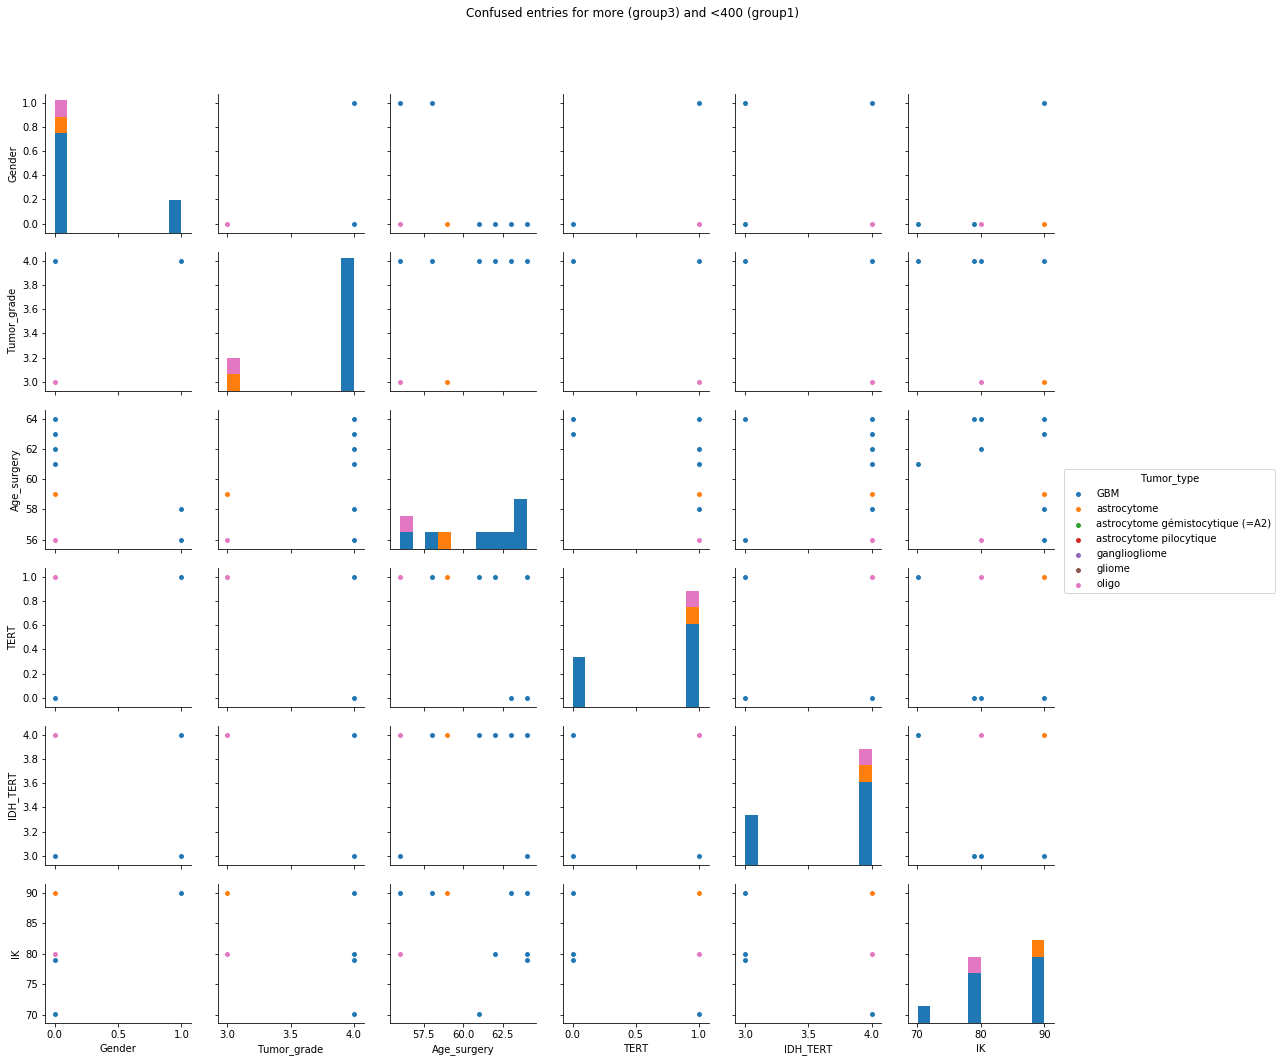

In [65]:
g5 = sns.pairplot(data=cfmore1,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g5.fig.suptitle('Confused entries for more (group3) and <400 (group1)') 
g5.savefig(results_path + "3rd-1st Group GBM confused patients")

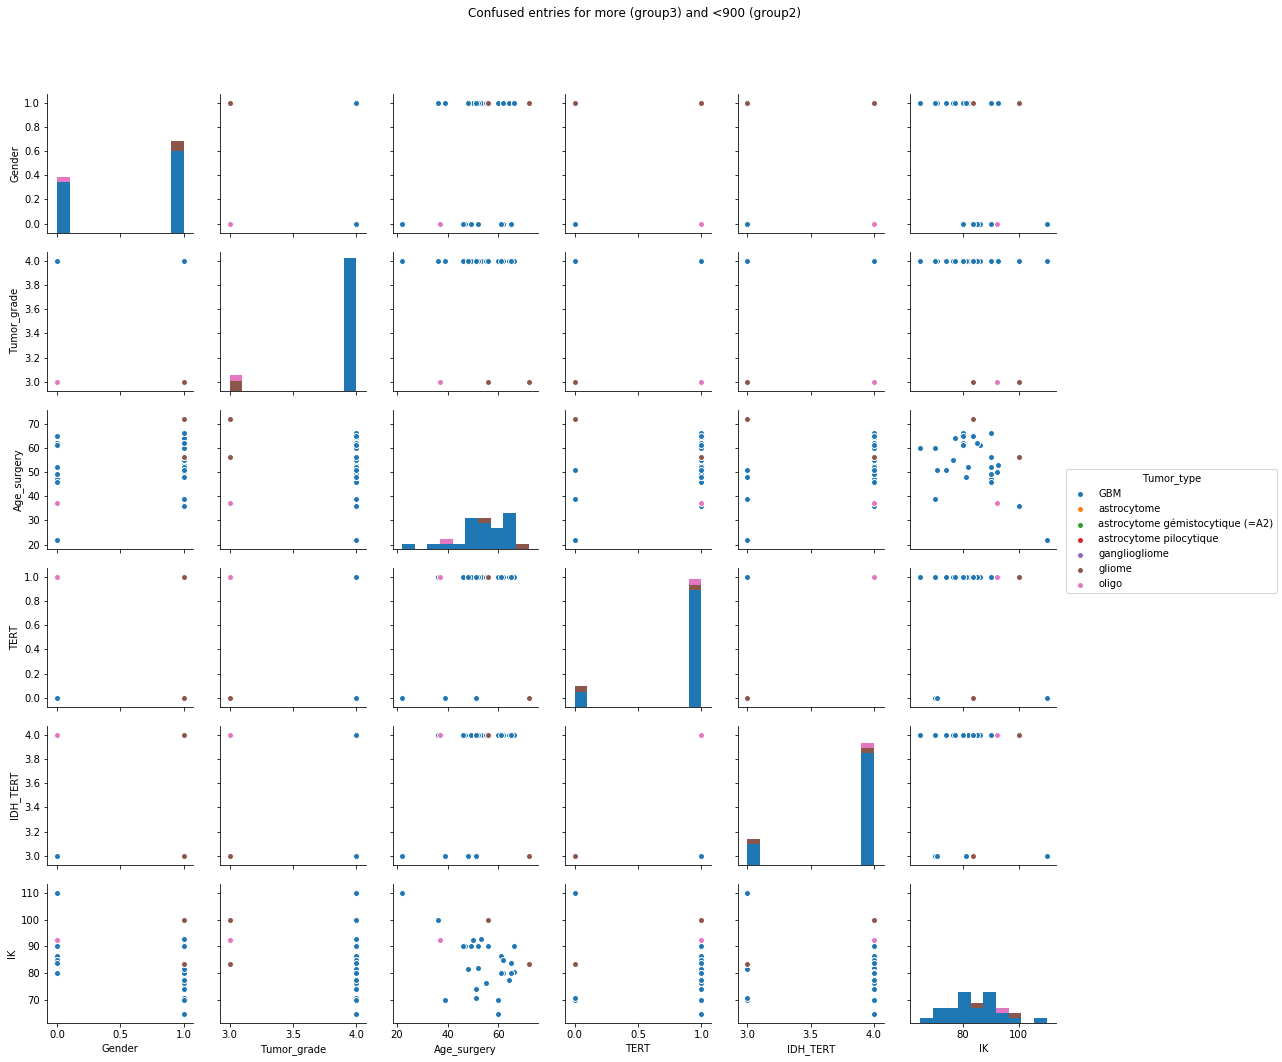

In [66]:
g6 = sns.pairplot(data=cfmore2,vars=["Gender","Tumor_grade","Age_surgery","TERT","IDH_TERT","IK"],hue="Tumor_type");
plt.subplots_adjust(top=0.9)
g6.fig.suptitle('Confused entries for more (group3) and <900 (group2)') 
g6.savefig(results_path + "3rd-2nd Group GBM confused patients")

# XGBoost Gradient Boosting 

In [21]:
from xgboost import XGBClassifier

## Baseline XGBoost

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


             precision    recall  f1-score   support

    8months       0.37      0.55      0.44       119
   1.5years       0.19      0.20      0.19       133
   2.5years       0.25      0.12      0.16       116

avg / total       0.27      0.29      0.26       368

Accuracy: 0.28532608695652173


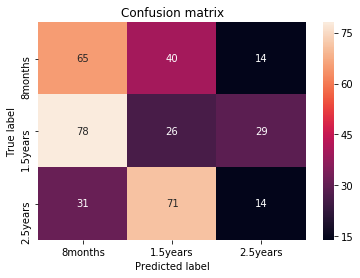

In [22]:
boost_model = XGBClassifier()
boost_model.fit(X_train, Y_train)
boost_model.score(X_test,Y_test)

probas = boost_model.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)

evaluation.plot_report(Y_test, l[y_pred], labels)

/Users/patricfulop/anaconda3/envs/cancer/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


For 3 class problem --- Accuracy: 0.42934782608695654 and Logloss: 1.3272589974272389
             precision    recall  f1-score   support

    8months       0.39      0.50      0.44       119
   1.5years       0.28      0.29      0.28       133
   2.5years       0.24      0.16      0.19       116

avg / total       0.30      0.32      0.31       368

Accuracy: 0.3179347826086957


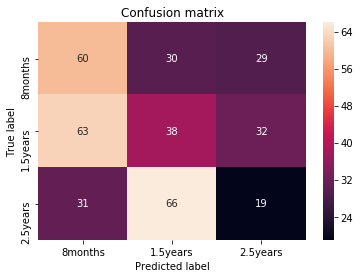

In [23]:
# Gradient Boosting classifiers based on validation/test
# What are the key aspects of tuning the XGBoost Tree
gbc = XGBClassifier(learning_rate= 0.03, 
                                 n_estimators=300,
                                 max_depth =30,                          
                                 random_state = 1123)
gbc.fit(X_train, Y_train)

# Accuracy
accuracy = gbc.score(X_test,Y_test)

# Error 
probas = gbc.predict_proba(X_test)
y_pred = np.argmax(probas, axis=1)
error = log_loss(Y_test,probas)
print("For {0} class problem --- Accuracy: {1} and Logloss: {2}".format(len(labels), accuracy, error))    
evaluation.plot_report(Y_test, l[y_pred], labels)

In [ ]:
#X_tr_merge = pd.concat((X_train,X_test)).as_matrix()
#Y_tr_merge = pd.concat((Y_train,Y_test)).as_matrix()

In [ ]:
#plt.figure()
#evaluation.plot_confusion_matrix(cfm, norm=True, classes=labels)
#plt.xlabel('Interpreted cluster label')
#plt.show()

In [32]:
#fig, ax = plt.subplots(1, 3, figsize=(15,10))

#ax[0].scatter(estimators_range, errors)
#ax[0].set_ylabel('Log-loss error on validation set')
#ax[0].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[1].scatter(estimators_range, accuracies)
#ax[1].set_ylabel('Accuracies on validation set')
#ax[1].set_xlabel('Number of estimators for Random Forest Classifier');

#ax[2].scatter(estimators_range, roc_auc)
#ax[2].set_ylabel('AUC on validation set')
#ax[2].set_xlabel('Number of estimators for Random Forest Classifier');


## Miscellaneous - Exporting data to a tree style graph for interpretation

In [ ]:
# Feature importance in descending order
feat_order_ind = np.argsort(rf_ind.feature_importances_)[::-1] # In descending order
print('50 most important features in order of decreasing importance: \n{}'.
      format(train_A.drop(["imgId", "is_person"], axis=1).columns[feat_order_ind[0:50]]))

title = 'Learning Curves (NN with tuned hyperparameters)'    
estimator = nn01_opt # regressor with tuned hyperparameters 
plot_learning_curve(estimator, title, sine_X_train, sine_y_train, 
                    ylim=(-10., 0.), cv=5, n_jobs=-1, scoring='mean_squared_error')
plt.grid(True)
plt.show()

########### 

dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names= df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
    class_names = labels,  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)
graph
#To create a file do this:
#To create a file do this:
with open("tree.dot", 'w') as f:
     f = export_graphviz(dt, out_file=f,
                         feature_names = df_clean.drop(["life_expectancy_bin","life_expectancy"], axis=1).columns,  
                         class_names = labels,   
                         filled=True, rounded=True,  
                         special_characters=True)